In [53]:
"""
Algorithm implementation
"""
import pickle
import numpy as np
import matplotlib.pyplot as plt
from essai import constellation
import scipy

from scipy.io.wavfile import read
from scipy.signal import spectrogram
from skimage.feature import peak_local_max
import random

# ----------------------------------------------------------------------------
# Create a fingerprint for an audio file based on a set of hashes
# ----------------------------------------------------------------------------


class Encoding:

    """
    Class implementing the procedure for creating a fingerprint 
    for the audio files

    The fingerprint is created through the following steps
    - compute the spectrogram of the audio signal
    - extract local maxima of the spectrogram
    - create hashes using these maxima

    """
    def __init__(self, path, tmin = 0, duration = None):

        """
        Class constructor

        To Do
        -----

        Initialize in the constructor all the parameters required for
        creating the signature of the audio files. These parameters include for
        instance:
        - the window selected for computing the spectrogram
        - the size of the temporal window 
        - the size of the overlap between subsequent windows
        - etc.

        All these parameters should be kept as attributes of the class.
        """

        # Insert code here
        self.fs, self.s = read(path)
        if duration != None : 
          self.s = self.s[tmin*self.fs : tmin*self.fs + duration*self.fs]
        else :
          self.s = self.s[tmin*self.fs :]
        #POUR TESTER PLUS VITE
        #self.s = self.s[:90000]
        self.window = 128
        self.noverlap = 32
        self.n_coeff = len(self.s)
      #   self.window = scipy.signal.get_window('triang', 128)
      #   self.window_size = len(self.window)

    def energie_min(self):      #on ajoute les points portant le plus d'énergie l'un après l'autre jusqu'à arriver à 90% de l'énergie totale.


          E_tot = np.sum(np.square(self.Sxx))
          print(f"l'énergie du signal est {E_tot}, le nombre de points est {np.prod(self.Sxx.shape)}")
          E = 0
          threshold_list = np.sort(self.Sxx,axis = None)[::-1]
          print(f"Threshold list : {threshold_list}")
          i = 0
          while E < 0.9*E_tot:            #on calcule l'énergie sur la durée entière, en ajoutant à chaque fois de nouvelles fréquences.
              threshold = threshold_list[i]
              mask = self.Sxx > threshold
              selected_sxx = self.Sxx[mask]
              E = np.sum(selected_sxx**2)
              i += 1
          print(f"la nouvelle énergie est {E}, soit {E/E_tot} % de la valeur initiale et le nombre de points est {len(self.Sxx[self.Sxx > threshold])}")
          indices_f, indices_t = np.indices(self.Sxx.shape)
          indices_f = indices_f[mask]
          indices_t = indices_t[mask]
          print("points selectionnés:")
          print(self.Sxx[indices_f,indices_t])
          self.Sxx[~mask] = 0
          i=1
          while i < len(self.Sxx):            #on supprime les lignes (fréquences) portant très peu d'énergie
            if np.sum(self.Sxx[-i]) == 0:
              self.Sxx = self.Sxx[:-1]
              self.f = self.f[:-1]
            else :
              i += 1
          return(indices_f, indices_t)

    def process(self, fs, s):

        """

        To Do
        -----

        This function takes as input a sampled signal s and the sampling
        frequency fs and returns the fingerprint (the hashcodes) of the signal.
        The fingerprint is created through the following steps
        - spectrogram computation
        - local maxima extraction
        - hashes creation

        Implement all these operations in this function. Keep as attributes of
        the class the spectrogram, the range of frequencies, the anchors, the 
        list of hashes, etc.

        Each hash can conveniently be represented by a Python dictionary 
        containing the time associated to its anchor (key: "t") and a numpy 
        array with the difference in time between the anchor and the target, 
        the frequency of the anchor and the frequency of the target 
        (key: "hash")


        Parameters
        ----------

        fs: int
           sampling frequency [Hz]
        s: numpy array
           sampled signal
        """

        # Insert code here
        self.spectr = spectrogram(s,fs,nperseg = self.window,noverlap = self.noverlap)
        self.f, self.t, self.Sxx = self.spectr
        print("Sxx :")
        print(self.Sxx)
        self.energie_min()


        #self.spec = scipy.signal.spectrogram(s, fs, self.window, noverlap = 32)
        #self.f, self.t, self.Sxx = scipy.signal.spectrogram(s, fs, return_onesided=False)
        self.constellation_indices = peak_local_max(self.Sxx, min_distance=50, exclude_border = False,indices = True)
        print("indices :")
        print(self.constellation_indices)
        t = self.t[self.constellation_indices[:,1]]
        f = self.f[self.constellation_indices[:,0]]
        n = len(t)
        delta_t,detla_f = 1,500    #définition des seuils 

        self.hashes = []
        for a in range(n):
          for i in range(a,n):
            dt = t[i] - t[a]
            if abs(dt) < delta_t and abs(f[a] - f[i]) < detla_f:
              hash = {"t" : t[a], "hash":np.array([dt,f[a],f[i]])}
              self.hashes.append(hash)
              



    def display_spectrogram(self):
       indices_f, indices_t = self.energie_min()
       plt.figure(figsize=(10,10))
       plt.pcolormesh(self.t,self.f,self.Sxx,shading='gouraud')
       t = self.t[self.constellation_indices[:,1]]
       f = self.f[self.constellation_indices[:,0]]
       plt.scatter(t,f,color = 'red', marker = 'o')

    def compare_distance(self):         #teste quelle part de l'énergie et combien de maxima restent en augmentant la distance entre les maxima
            E_tot = np.sum(self.Sxx**2)
            dist_list = [1,5,10,50,100,500,1000]
            for distance in dist_list:
              mask_maxi = peak_local_max(self.Sxx, min_distance=distance, exclude_border = False, indices = False)
              constellation = self.Sxx[mask_maxi]
              E = np.sum(constellation**2)
              nb_max = np.sum(mask_maxi)
              print(f"distance : {distance}, énergie :{E/E_tot}%, nombre de maxima :{nb_max}")

        #Construisons la constellation du morceau:
    delta_t = 0.01

        
        # def constellation(delta_t,coord_maxima):
        #    hash = {}
        #    x = coord_maxima[:,0]
        #    y = coord_maxima[:,1]
        #    for i in range(len(x)):
        #       for j in range(i,len(x)):
        #          if abs(x[i] - x[j]) < delta_t and abs(y[i] - y[j]):
        #             hash[f"{i}"] = {abs(i - j), y[i],y[j]}
        #             return hash
        # self.constellation = constellation(self.t, self.maxi)
        # return self.constellation

Sxx :
[[5.8000164e+00 2.8141711e+02 1.9887949e+02 ... 3.9850471e+01
  8.0249274e-01 4.0637650e+02]
 [1.0535721e+04 2.9012062e+04 2.6427191e+04 ... 4.4133508e+04
  1.1015218e+04 6.4198545e+03]
 [5.4841538e+03 1.0171842e+04 7.0583843e+03 ... 2.7092710e+03
  1.1457172e+03 1.0545490e+03]
 ...
 [1.6975260e-06 5.2391056e-07 2.8385837e-06 ... 3.3387087e-06
  2.4804060e-06 6.7614242e-06]
 [1.9855081e-07 1.2278419e-06 1.5891428e-07 ... 1.4668282e-06
  1.0402601e-05 1.1501148e-06]
 [1.4225094e-06 1.8194447e-09 1.2432159e-09 ... 2.2210845e-06
  6.0077538e-09 1.0364301e-05]]
l'énergie du signal est 706095808512.0, le nombre de points est 67665
Threshold list : [1.24737148e+05 1.22809375e+05 1.12541250e+05 ... 3.02594165e-11
 5.31172935e-12 3.87816054e-13]
la nouvelle énergie est 635714338816.0, soit 0.9003230333328247 % de la valeur initiale et le nombre de points est 402
points selectionnés:
[ 29012.062  26427.191  61248.562  31697.164  24116.283  20322.068
  19840.955  59967.906  44324.598  3206

c:\Users\antoi\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


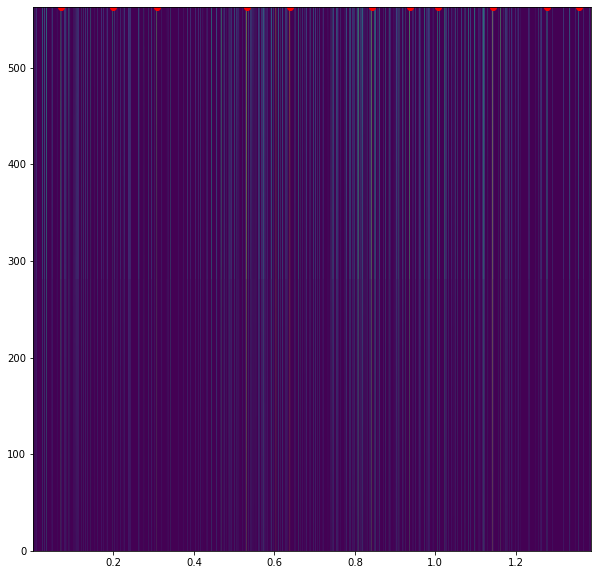

In [52]:
# ----------------------------------------------
# Run the script
# ----------------------------------------------
if __name__ == '__main__':

    encoder = Encoding('samples\In The Throes - Asher Fulero.wav',tmin = 0, duration = None)
    fs, s = read('samples\In The Throes - Asher Fulero.wav')
    encoder.process(fs, s[800000:900000])
    encoder.display_spectrogram()
    # #encoder.display_spectrogram(display_anchors=True)
    print(len(encoder.hashes))


In [ ]:
# ----------------------------------------------------------------------------
# Compares two set of hashes in order to determine if two audio files match
# ----------------------------------------------------------------------------

class Matching:

    """
    Compare the hashes from two audio files to determine if these
    files match

    Attributes
    ----------

    hashes1: list of dictionaries
       hashes extracted as fingerprints for the first audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    hashes2: list of dictionaries
       hashes extracted as fingerprint for the second audiofile. Each hash 
       is represented by a dictionary containing the time associated to
       its anchor (key: "t") and a numpy array with the difference in time
       between the anchor and the target, the frequency of the anchor and
       the frequency of the target (key: "hash")

    matching: numpy array
       absolute times of the hashes that match together

    offset: numpy array
       time offsets between the matches
    """

    def __init__(self, hashes1, hashes2):

        """
        Class constructor

        Compare the hashes from two audio files to determine if these
        files match

        To Do
        -----

        Implement a code establishing correspondences between the hashes of
        both files. Once the correspondences computed, construct the 
        histogram of the offsets between hashes. Finally, search for a criterion
        based on the histogram that allows to determine if both audio files 
        match

        Parameters
        ----------

        hashes1: list of dictionaries
           hashes extracted as fingerprint for the first audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target

        hashes2: list of dictionaries
           hashes extracted as fingerprint for the second audiofile. Each hash 
           is represented by a dictionary containing the time associated to
           its anchor (key: "t") and a numpy array with the difference in time
           between the anchor and the target, the frequency of the anchor and
           the frequency of the target
        """


        self.hashes1 = hashes1
        self.hashes2 = hashes2

        # Insert code here
        



             
    def display_scatterplot(self):
       """
        Display through a scatterplot the times associated to the hashes
        that match
        """
    
       
       keys1 = hashes1.key()
       keys2 = hashes2.key()
       time_cloud = [[],[]]
       for k1 in keys1:
           for k2 in keys2:
              if k1 == k2:
                 time_cloud[0].append(k1 - hashes1[f"k1"][0])
                 time_cloud[1].append(k2 - hashes2[f"k2"][0])
       plt.scatter(time_cloud[0],time_cloud[1])
       plt.show()


      

    def display_histogram(self):

        """
        Display the offset histogram
        """

        # Insert code here

In [91]:
indices = np.array([[0,1],[1,1]],dtype=bool)
print(indices)
test = np.identity(2)
print(test)
test[indices]

[[False  True]
 [ True  True]]
[[1. 0.]
 [0. 1.]]


array([0., 0., 1.])